In [51]:
import networkx as nx
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

from random import sample
from math import ceil, sqrt

# Instance Reading

In [52]:
# Create a random planar graph:
graph = nx.convert_node_labels_to_integers(nx.triangular_lattice_graph(2, 2))
edges_to_remove = sample(list(graph.edges()), k=int(0.3 * graph.number_of_edges()))
graph.remove_edges_from(edges_to_remove)

# Read an input graph:
# graph = nx.read_edgelist('instances/planar_1.in', create_using=nx.Graph, nodetype=int)

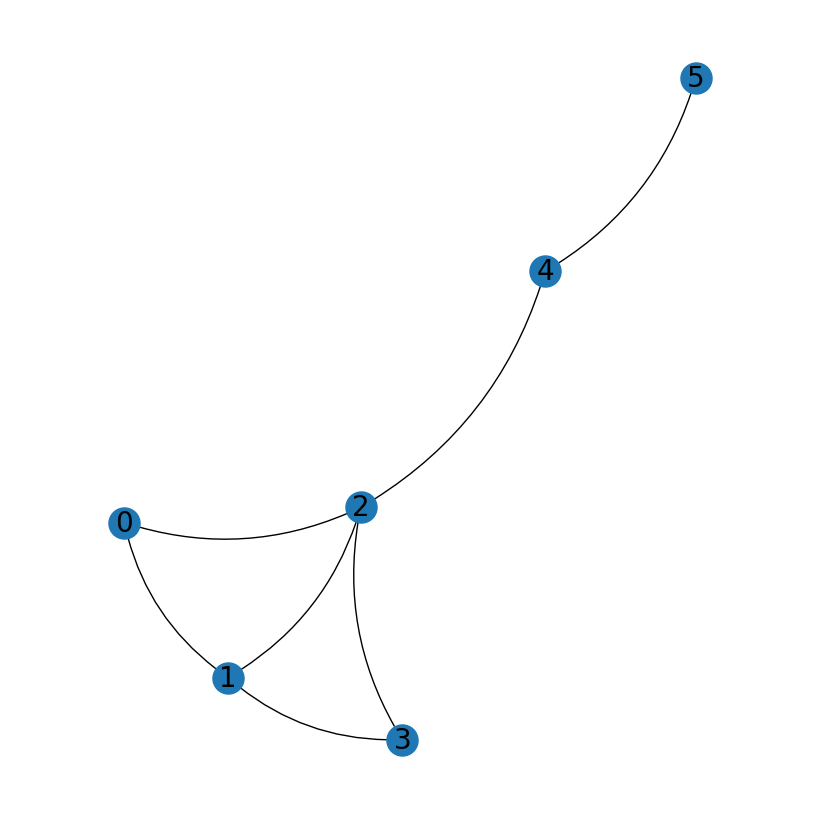

In [53]:
n = len(graph)
V = graph.nodes()
E = graph.edges()

# Plot the graph
plt.figure(figsize=(8, 8))
nx.draw(graph, with_labels=True, node_size=500, font_size=20, arrows=True, connectionstyle='arc3,rad=0.2')
plt.axis('equal')
plt.show()

# Create the Model

In [54]:
m = gp.Model('grid-drawing')

## Dimensions bounds:
WIDTH, HEIGHT = 10, 10

## Variables:
width = m.addVar(ceil(sqrt(n)) - 1, WIDTH, 0, GRB.INTEGER, 'w')
height = m.addVar(1, HEIGHT, 0, GRB.INTEGER, 'h')
x = m.addVars(V, lb=0, ub=WIDTH, vtype=GRB.INTEGER, name='x')
y = m.addVars(V, lb=0, ub=HEIGHT, vtype=GRB.INTEGER, name='y')
m.update()

m.addConstrs(((x[u] - x[v]) ** 2 + (y[u] - y[v]) ** 2 >= 1
              for u in V for v in V if u < v), name='diff')  # all used grid points are distinct
m.addQConstr((height + 1) * (width + 1) >= n, name='min_num')  # minimum number of grid points
m.addConstrs((x[i] <= width for i in V), name='x_bound')  # all x's must be within the bounding box
m.addConstrs((y[i] <= height for i in V), name='y_bound')  # all y's must be within the bounding box
m.addConstr(width >= height, name='lied_down')  # remove some symmetries by forcing a lied down box
m.update()

In [55]:
def addSOSCertificate(model, e, f):
    """
    Adds SOS certificate constraints for a segment pair defined by seg = (a, b, c, d)
    where:
       - Segment AB is defined by points a=(ax, ay) and b=(bx, by)
       - Segment CD is defined by points c=(cx, cy) and d=(dx, dy)

    The SOS certificate is of the form:
         P(te,tf) - ε = z(te,tf)^T Q z(te,tf)
    with z(te,tf) = [1, te, tf]^T and Q = V^T V.

    This function:
      - Creates a certificate margin variable ε (with a lower bound 1e-6).
      - Creates a 3x3 factor matrix V (stored in a dictionary) for this certificate.
      - Computes helper expressions:
            L = b - d,
            D_te = a - b, and
            D_tf = d - c.
      - Computes the polynomial coefficients:
            c0 = Lx² + Ly²,
            c1 = 2*(Lx*D_te_x + Ly*D_te_y),
            c2 = 2*(Lx*D_tf_x + Ly*D_tf_y),
            c3 = D_te_x² + D_te_y²,
            c4 = 2*(D_te_x*D_tf_x + D_te_y*D_tf_y),
            c5 = D_tf_x² + D_tf_y².
      - Adds coefficient-matching constraints:
            ∑ₖ V[k,0]²          = c0 - ε
            2∑ₖ V[k,0]*V[k,1]    = c1
            2∑ₖ V[k,0]*V[k,2]    = c2
            ∑ₖ V[k,1]²          = c3
            2∑ₖ V[k,1]*V[k,2]    = c4
            ∑ₖ V[k,2]²          = c5
    Returns:
        eps  -- the certificate margin variable for this segment.
        Vseg -- dictionary of the 3x3 factor variables.
    """
    # Unpack segment indices.
    ax, bx, cx, dx = x[e[0]], x[e[1]], x[f[0]], x[f[1]]
    ay, by, cy, dy = y[e[0]], y[e[1]], y[f[0]], y[f[1]]

    # Certificate margin ε.
    eps = model.addVar(lb=1e-8, name=f"epsilon[{e + f}]")

    # Create a 3x3 matrix V for the certificate.
    Vseg = {}
    for i in range(3):
        for j in range(3):
            Vseg[i, j] = model.addVar(lb=-GRB.INFINITY, name=f"V[{e + f}]_{i}_{j}")

    # Helper expressions (using global coordinate variables):
    Lx = bx - dx
    Ly = by - dy
    D_te_x = ax - bx
    D_te_y = ay - by
    D_tf_x = dx - cx
    D_tf_y = dy - cy

    # Polynomial coefficients.
    c0_expr = Lx * Lx + Ly * Ly
    c1_expr = 2 * (Lx * D_te_x + Ly * D_te_y)
    c2_expr = 2 * (Lx * D_tf_x + Ly * D_tf_y)
    c3_expr = D_te_x * D_te_x + D_te_y * D_te_y
    c4_expr = 2 * (D_te_x * D_tf_x + D_te_y * D_tf_y)
    c5_expr = D_tf_x * D_tf_x + D_tf_y * D_tf_y

    # Coefficient matching constraints:
    model.addConstr(
        gp.quicksum(Vseg[k, 0] * Vseg[k, 0] for k in range(3)) == c0_expr - eps,
        name=f"Q11[{e + f}]"
    )
    model.addConstr(
        2 * gp.quicksum(Vseg[k, 0] * Vseg[k, 1] for k in range(3)) == c1_expr,
        name=f"Q12[{e + f}]"
    )
    model.addConstr(
        2 * gp.quicksum(Vseg[k, 0] * Vseg[k, 2] for k in range(3)) == c2_expr,
        name=f"Q13[{e + f}]"
    )
    model.addConstr(
        gp.quicksum(Vseg[k, 1] * Vseg[k, 1] for k in range(3)) == c3_expr,
        name=f"Q22[{e + f}]"
    )
    model.addConstr(
        2 * gp.quicksum(Vseg[k, 1] * Vseg[k, 2] for k in range(3)) == c4_expr,
        name=f"Q23[{e + f}]"
    )
    model.addConstr(
        gp.quicksum(Vseg[k, 2] * Vseg[k, 2] for k in range(3)) == c5_expr,
        name=f"Q33[{e + f}]"
    )


def addContainmentCertificate(model, triplet):
    """
    Adds constraints to ensure that segment AB is not completely contained in segment AC.

    Parameters:
        model      -- Gurobi model
        x, y       -- Coordinate dictionaries
        triplet    -- (a, b, c) indices defining points A, B, and C
        cert_index -- Unique index for constraint naming

    Constraints:
        We enforce that B is not strictly between A and C in a convex combination sense.
        This is done using an SOS-based quadratic constraint.
    """
    # Unpack segment indices.
    ax, bx, cx = x[triplet[0]], x[triplet[1]], x[triplet[2]]
    ay, by, cy = y[triplet[0]], y[triplet[1]], y[triplet[2]]

    # Define vector differences
    AB_x = bx - ax
    AB_y = by - ay
    AC_x = cx - ax
    AC_y = cy - ay

    # Define SOS decision variable (margin for non-containment)
    epsilon = model.addVar(lb=1e-8, name=f"epsilon_cont[{e + f}]")

    # Create a 2×2 factor matrix V (for a rank-1 SOS decomposition)
    Vcont = {}
    for i in range(2):
        for j in range(2):
            Vcont[i, j] = model.addVar(lb=-GRB.INFINITY, name=f"Vcont[{e + f}]_{i}_{j}")

    # Quadratic form for containment prevention:
    # We ensure that AB is not a scaled version of AC (i.e., AB ≠ λ * AC for 0 < λ < 1)
    c0_expr = AB_x * AB_x + AB_y * AB_y  # |AB|^2
    c1_expr = -2 * (AB_x * AC_x + AB_y * AC_y)  # -2(AB • AC)
    c2_expr = AC_x * AC_x + AC_y * AC_y  # |AC|^2

    # SOS constraints enforcing positive definiteness:
    model.addConstr(
        gp.quicksum(Vcont[k, 0] * Vcont[k, 0] for k in range(2)) == c0_expr - epsilon,
        name=f"Q11_cont[{e + f}]"
    )
    model.addConstr(
        2 * gp.quicksum(Vcont[k, 0] * Vcont[k, 1] for k in range(2)) == c1_expr,
        name=f"Q12_cont[{e + f}]"
    )
    model.addConstr(
        gp.quicksum(Vcont[k, 1] * Vcont[k, 1] for k in range(2)) == c2_expr,
        name=f"Q22_cont[{e + f}]"
    )

In [56]:
for e in E:
    for f in E:
        if e < f:
            if not set(e) & set(f):
                addSOSCertificate(m, e, f)
            else:
                triplet = tuple(set(e) & set(f)) + tuple(set(e) ^ set(f))
                addContainmentCertificate(m, triplet)
m.update()

# Model Solving

In [57]:
## Objective function:
# m.setObjective(0)
m.setObjective(width + height, GRB.MINIMIZE)

## Solving:
try:
    m.optimize()
    print(f'\nFound a solution with bounding box {int(width.x)}x{int(height.x)}:')
    # Print coordinates for each node:
    for u in V():
        print(f'{u}: ({x[u].x:.2f}, {y[u].x:.2f})')

    # Save the model in a readable format:
    m.write('model.lp')

    # Print variable values after optimization
    print('\nVariables:')
    for var in m.getVars():
        print(f'{var.VarName}: {var.X}')
except gp.GurobiError as e:
    print(f'Error code {e.errno}: {e}')
except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Freedesktop SDK 23.08 (Flatpak runtime)")

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 13 rows, 164 columns and 26 nonzeros
Model fingerprint: 0xdde1d903
Model has 106 quadratic constraints
Variable types: 150 continuous, 14 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 2e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-08, 1e+01]
  RHS range        [0e+00, 0e+00]
  QRHS range       [1e+00, 5e+00]
Presolve removed 0 rows and 21 columns
Presolve time: 0.00s
Presolved: 928 rows, 420 columns, 2918 nonzeros
Presolved model has 51 quadratic constraint(s)
Presolved model has 225 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 364 continuous, 56 integer (0 binary)

# Visualize the computed solution

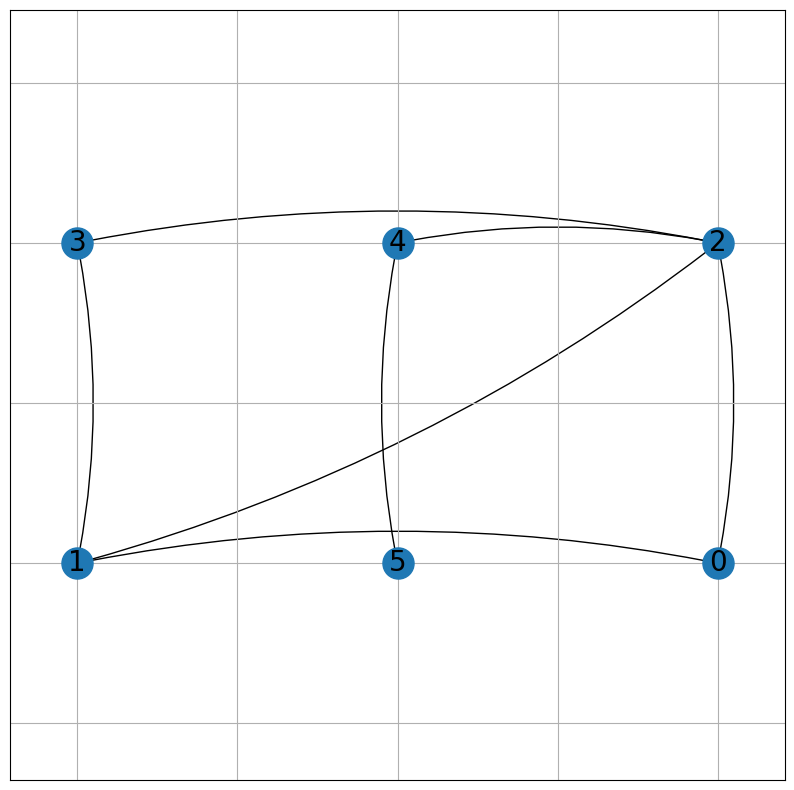

In [58]:
# Extract the coordinates:
pos = {node: (x[node].x, y[node].x) for node in V()}

# Plot the graph with the positions obtained from the model:
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(graph, pos=pos, node_size=500)
nx.draw_networkx_labels(graph, pos=pos, font_size=20)
nx.draw_networkx_edges(graph, pos=pos, arrows=True, connectionstyle='arc3,rad=0.1')
plt.axis('equal')
plt.grid()
plt.show()